In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
import skbio
import warnings
from qiime2.plugins.diversity_lib.methods import bray_curtis, unweighted_unifrac, weighted_unifrac
import qiime2

In [36]:
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

In [37]:
%cd /storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/

/storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed


## READ DATA

In [7]:
q2202_s1_ftable_file = 'qiita_2202/data_processing/interpolation_rarefaction/donorA_rarefied_interpolated_feces.csv'
q2202_s2_ftable_file = 'qiita_2202/data_processing/interpolation_rarefaction/donorB_rarefied_interpolated_feces.csv'
q2202_metadata_file = 'qiita_2202/2202_metadata.tsv'

q550_m_ftable_file = 'qiita_550/data_processing/interpolation_rarefaction/male_rarefied_interpolated_feces.csv'
q550_f_ftable_file = 'qiita_550/data_processing/interpolation_rarefaction/female_rarefied_interpolated_feces.csv'
q550_metadata_file = 'qiita_550/raw_data/550_metadata.txt'

In [8]:
#get dataframe only feces and no mislabeled
q2202_s1_df = pd.read_csv(q2202_s1_ftable_file, index_col = [0])
q2202_s2_df = pd.read_csv(q2202_s2_ftable_file, index_col = [0])

q550_m_df = pd.read_csv(q550_m_ftable_file, index_col = [0])
q550_m_df = q550_m_df.sort_index()
q550_f_df = pd.read_csv(q550_f_ftable_file, index_col = [0])
q550_f_df = q550_f_df.sort_index()

## ASV OVERLAP 

In [9]:
s1_columns = q2202_s1_df.columns
s2_columns = q2202_s2_df.columns
m_columns = q550_m_df.columns
f_columns = q550_f_df.columns

common_bacteria = len(list(set(s1_columns).intersection(s2_columns).intersection(m_columns).intersection(f_columns)))

In [10]:
s2_columns.shape
print('number of common bacteria: {}'.format(common_bacteria))

number of common bacteria: 166


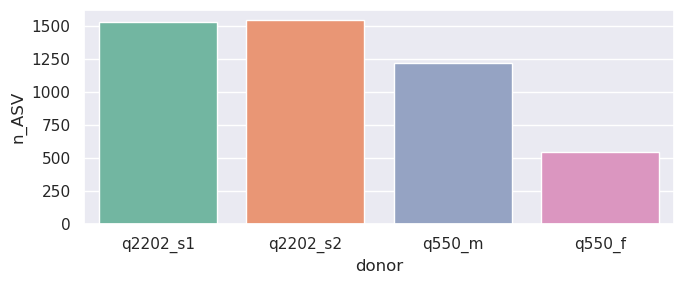

In [33]:
#plot number of bacteria for each person
days_df = pd.DataFrame(list(zip(['q2202_s1', 'q2202_s2', 'q550_m', 'q550_f'],
                                [len(s1_columns), len(s2_columns), len(m_columns), len(f_columns)])),
                       columns = ['donor', 'n_ASV'])


plt.figure(figsize = [7, 3])
sns.barplot(data = days_df, x = 'donor', y='n_ASV', palette = 'Set2')
plt.tight_layout()
plt.savefig('ASV.png')
plt.show()

## UMAP

In [46]:
q2202_s1_df['subject'] = 'q2202_s1'
q2202_s2_df['subject'] = 'q2202_s2'
q550_m_df['subject'] = 'q550_m'
q550_f_df['subject'] = 'q550_f'

appended_df = q2202_s1_df.append(q2202_s2_df).append(q550_m_df).append(q550_f_df)
appended_df = appended_df.fillna(0).reset_index()

In [119]:
umap_df = appended_df.drop(['subject', '#OTU ID'], axis = 1)

reducer = UMAP(random_state=42, metric = 'braycurtis')

X_transformed = reducer.fit_transform(umap_df.values)
UMAP_DF = pd.DataFrame(X_transformed, columns = ['C1', 'C2'])
UMAP_DF['subject'] = appended_df['subject'].tolist()
UMAP_DF['day'] = appended_df['#OTU ID'].tolist()

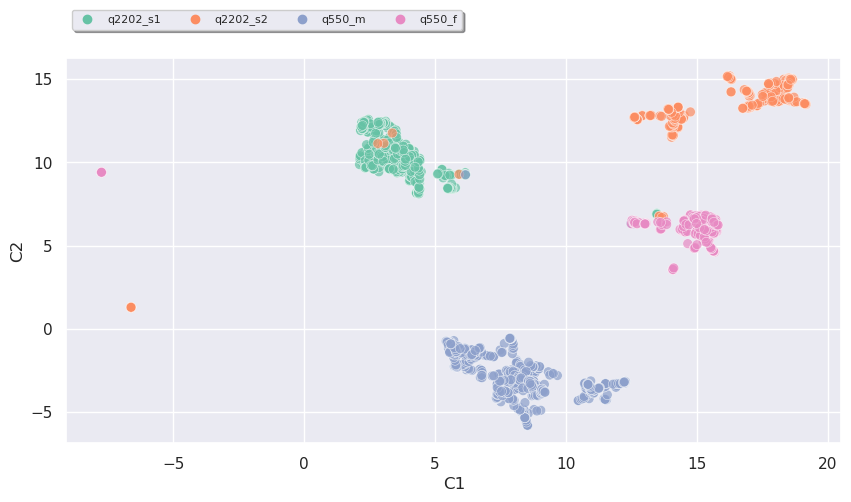

In [223]:
plt.figure(figsize = [10, 5])
sns.scatterplot(x = UMAP_DF['C1'],
                y = UMAP_DF['C2'],
                hue = UMAP_DF['subject'],
                s = 50,
                alpha = .7,
                palette = 'Set2',
                linewidth = .4
               )
plt.legend(loc='center left', bbox_to_anchor=(0, 1.1), fontsize = 8, ncol=len(UMAP_DF['subject']), shadow = True)

plt.savefig('UMAP.png')
plt.show()

## PCoA

In [82]:
APPENDED_DF = appended_df.drop(columns=['subject', '#OTU ID'])
APPENDED_DF.T.to_csv('appended_df.csv', sep = '\t')

In [ ]:
biom convert -i appended_df.csv -o appended_df.biom --to-hdf5

In [40]:
appended_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'appended_df.biom')
appended_feature_table_bray_curtis = bray_curtis(appended_feature_table)

In [41]:
def convert_distmat_to_dataframe(dist_mat):
    dist_mat_df = dist_mat.distance_matrix.view(skbio.DistanceMatrix).to_data_frame()
    return dist_mat_df

In [58]:
def plot_PCoA(beta_diversity_artifact):
    
    df = convert_distmat_to_dataframe(beta_diversity_artifact)
    
    PCoA_s1 = skbio.stats.ordination.pcoa(df.values)
    pcoa_features_s1 = PCoA_s1.samples
    pcoa_features_s1['subject'] = appended_df['subject'].tolist()
    
    #plot
    plt.figure(figsize = [8, 6])

    sns.scatterplot(x = pcoa_features_s1['PC1'], y = pcoa_features_s1['PC2'], hue = pcoa_features_s1['subject'], palette = 'Set2', s = 20, alpha = .7)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, .8))
    plt.tight_layout()
    plt.savefig('PCoA_BC_PC1_PC2.png')
    plt.show()
    
    plt.figure(figsize = [8, 6])
    sns.scatterplot(x = pcoa_features_s1['PC2'], y = pcoa_features_s1['PC3'], hue = pcoa_features_s1['subject'],palette = 'Set2', s = 20, alpha = .7)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, .8))
    plt.tight_layout()
    plt.savefig('PCoA_BC_PC2_PC3.png')
    plt.show()
    
    plt.figure(figsize = [8, 6])
    
    sns.scatterplot(x = pcoa_features_s1['PC1'], y = pcoa_features_s1['PC3'], hue = pcoa_features_s1['subject'], palette = 'Set2', s = 20, alpha = .7)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, .8))
    plt.tight_layout()
    plt.savefig('PCoA_BC_PC1_PC3.png')
    plt.show()

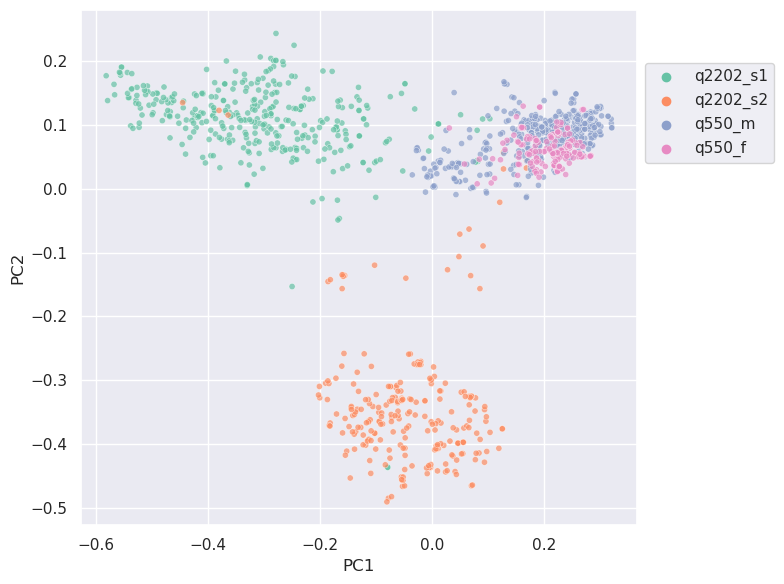

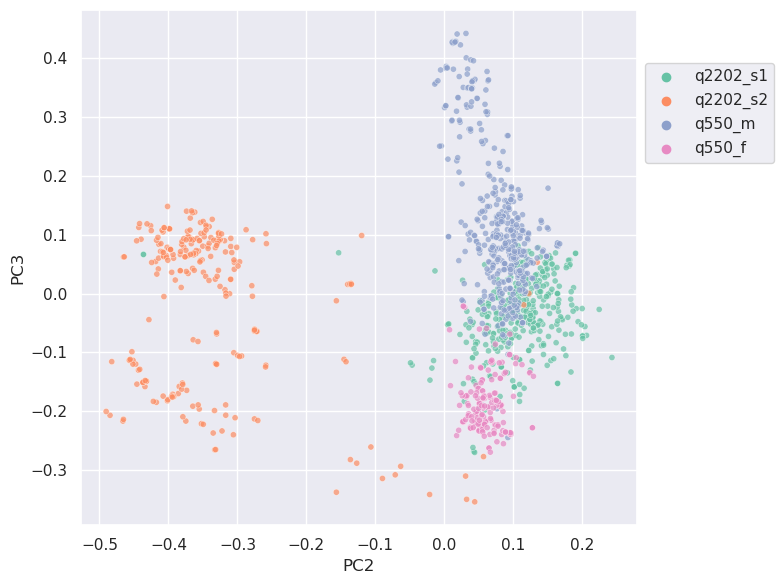

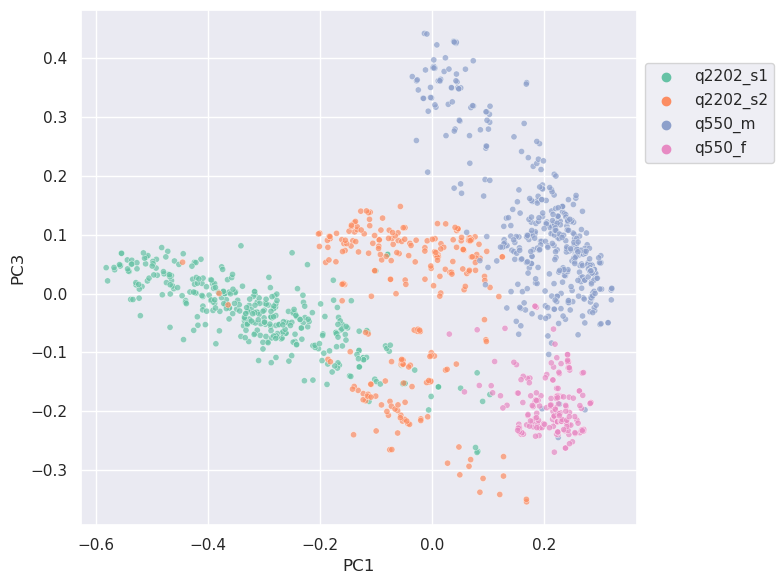

In [59]:
plot_PCoA(appended_feature_table_bray_curtis)

## separate PCoA for every subject 

In [84]:
%cd alpha_diversity_analysis_4_datasets/

/storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/alpha_diversity_analysis_4_datasets


In [85]:
q2202_s1_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'q2202_donorA_rarefied_interpolated_feces.biom')
q2202_s2_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'q2202_donorB_rarefied_interpolated_feces.biom')

q550_m_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'q550_male_rarefied_interpolated_feces.biom')
q550_f_feature_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", 'q550_female_rarefied_interpolated_feces.biom')

In [221]:
def plot_pca_subject(artifact, title):
    
    distmat = bray_curtis(artifact)
    df = convert_distmat_to_dataframe(distmat)
    timesteps = df.index.astype(int)
    
    
    PCoA = skbio.stats.ordination.pcoa(df.values)
    pcoa_features = PCoA.samples
    pcoa_features['timestep'] = timesteps
    
    plt.figure(figsize = [5, 3])
    sns.scatterplot(x = pcoa_features['PC1'], y = pcoa_features['PC2'], hue = pcoa_features['timestep'], s = 50, alpha = .7)
    plt.legend(loc='center left', bbox_to_anchor=(0, 1.08), ncol=len(pcoa_features['timestep']), shadow = True, fontsize = 6)
    plt.savefig('{}.png'.format(title))
    plt.show()

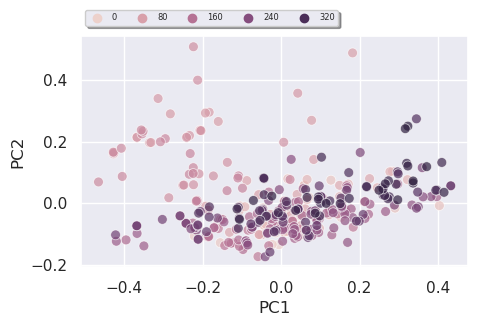

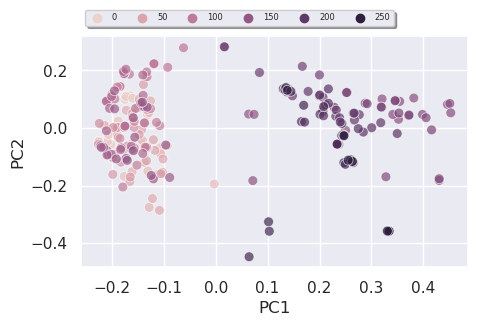

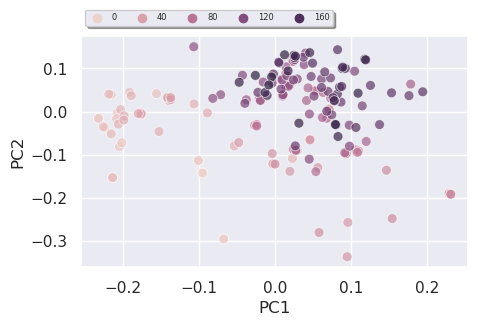

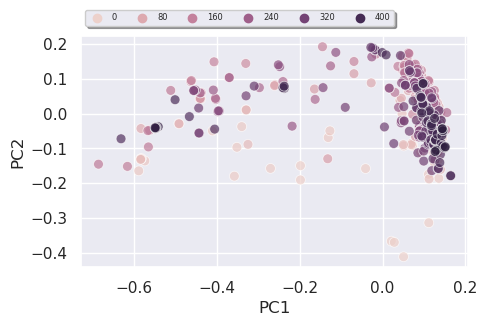

In [222]:
plot_pca_subject(q2202_s1_feature_table, 'q2202_s1_bc_pcoa')
plot_pca_subject(q2202_s2_feature_table, 'q2202_s2_bc_pcoa')
plot_pca_subject(q550_f_feature_table, 'q550_f_bc_pcoa')
plot_pca_subject(q550_m_feature_table, 'q550_m_bc_pcoa')

## PLOT HEATMAP OF TIMESTEPS BRAY CURTIS SIMILARITY

In [97]:
def plot_heatmap_subject(artifact, subject):
    
    distmat = bray_curtis(artifact)
    df = convert_distmat_to_dataframe(distmat)
    

    plt.figure(figsize = [10, 10])
    sns.heatmap(df)
    plt.title(subject)
    plt.tight_layout()
    plt.savefig('heatmap_bc_{}.png'.format(subject))
    plt.show()

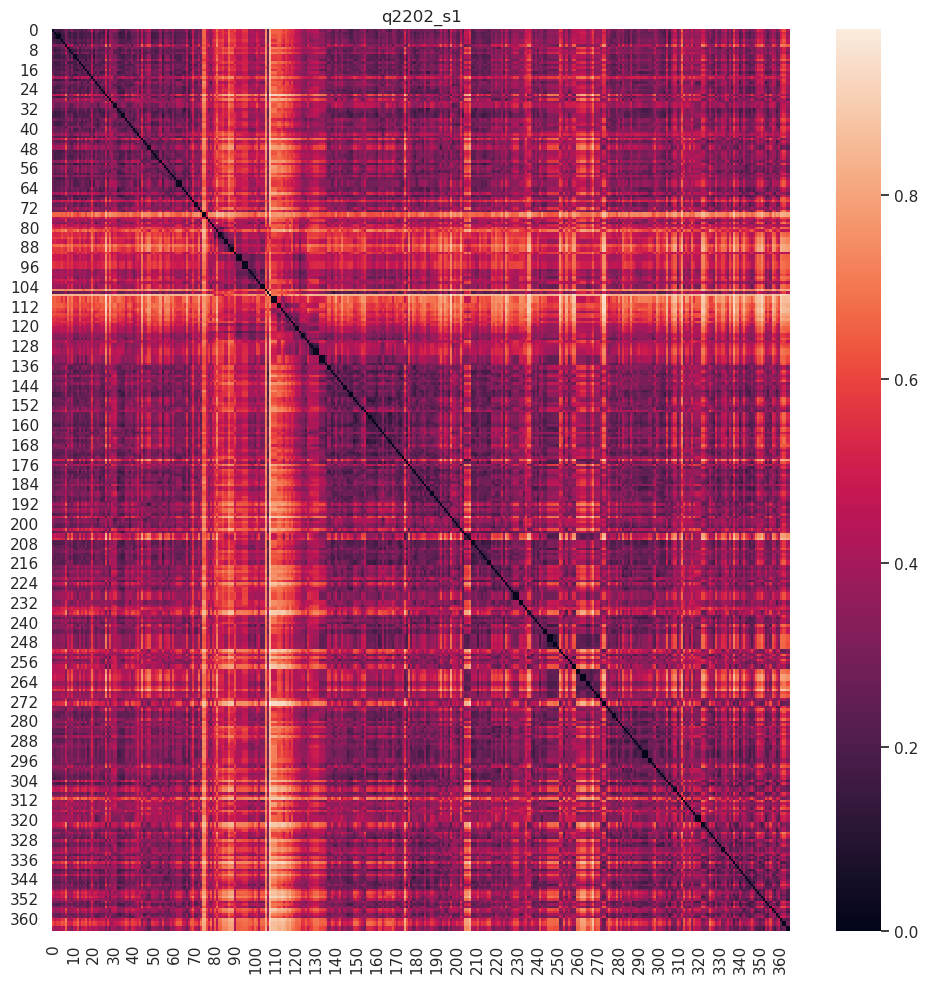

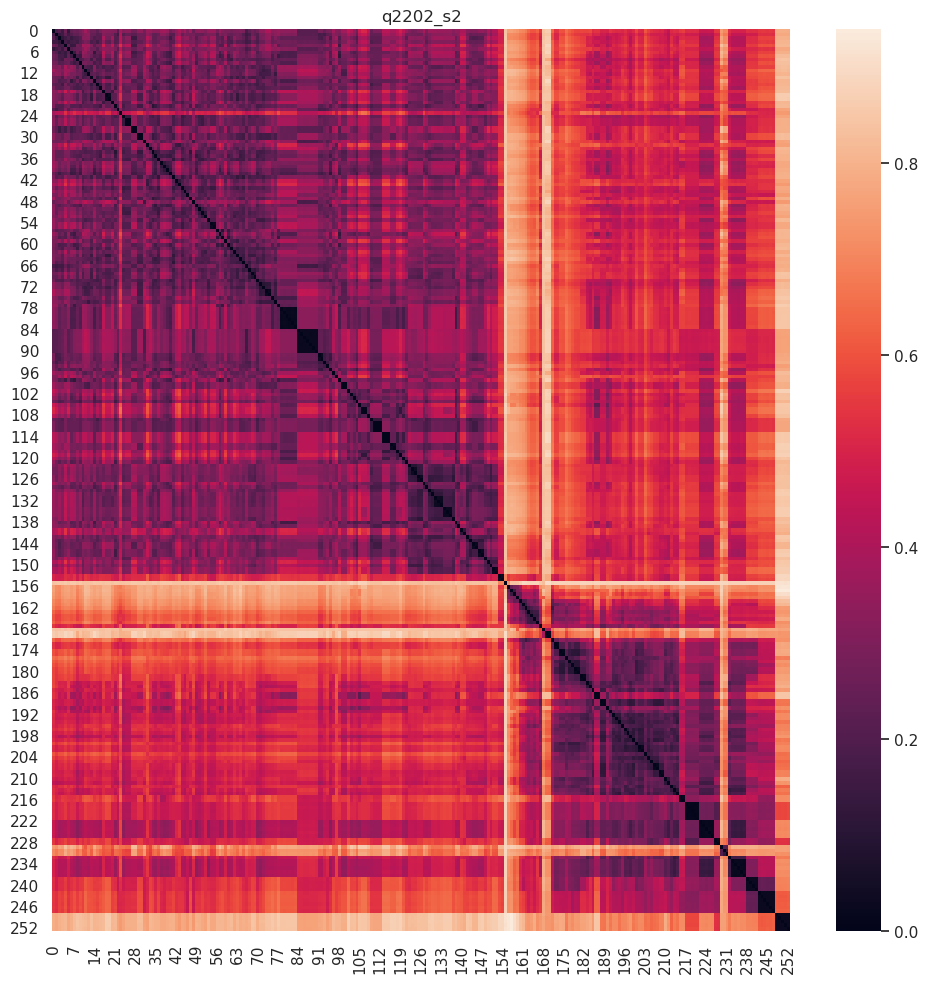

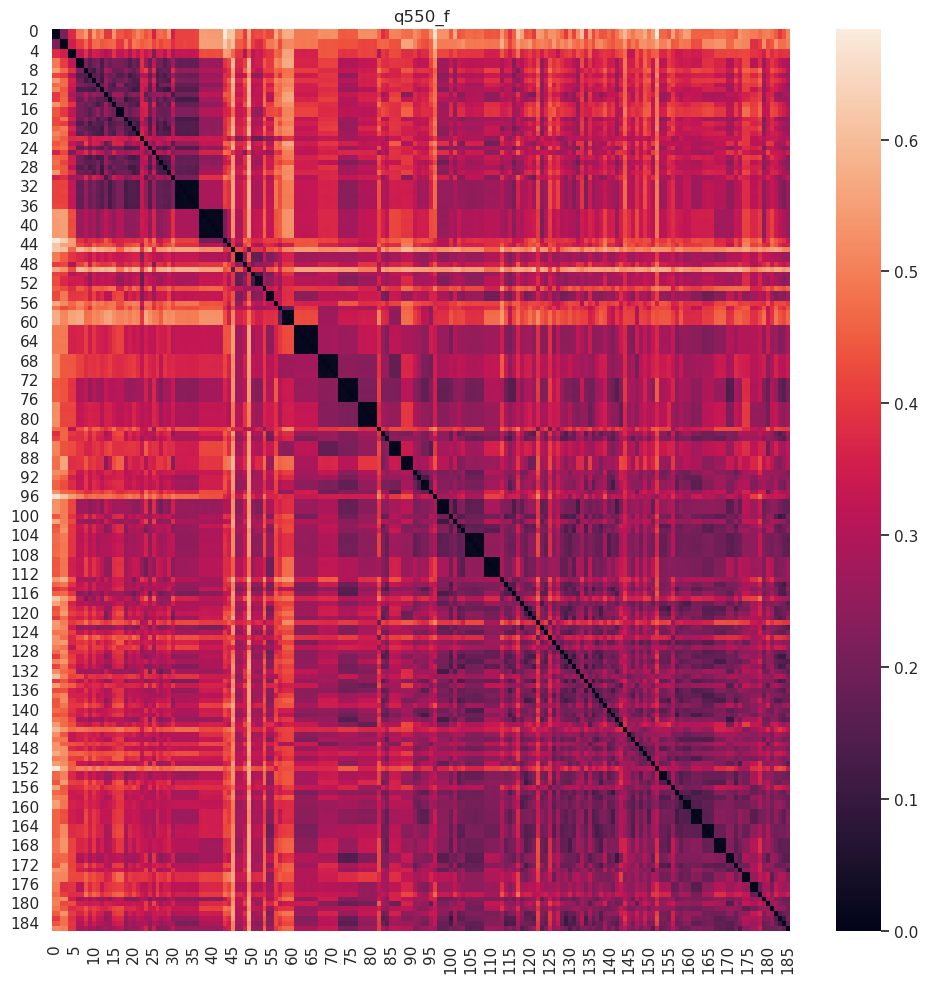

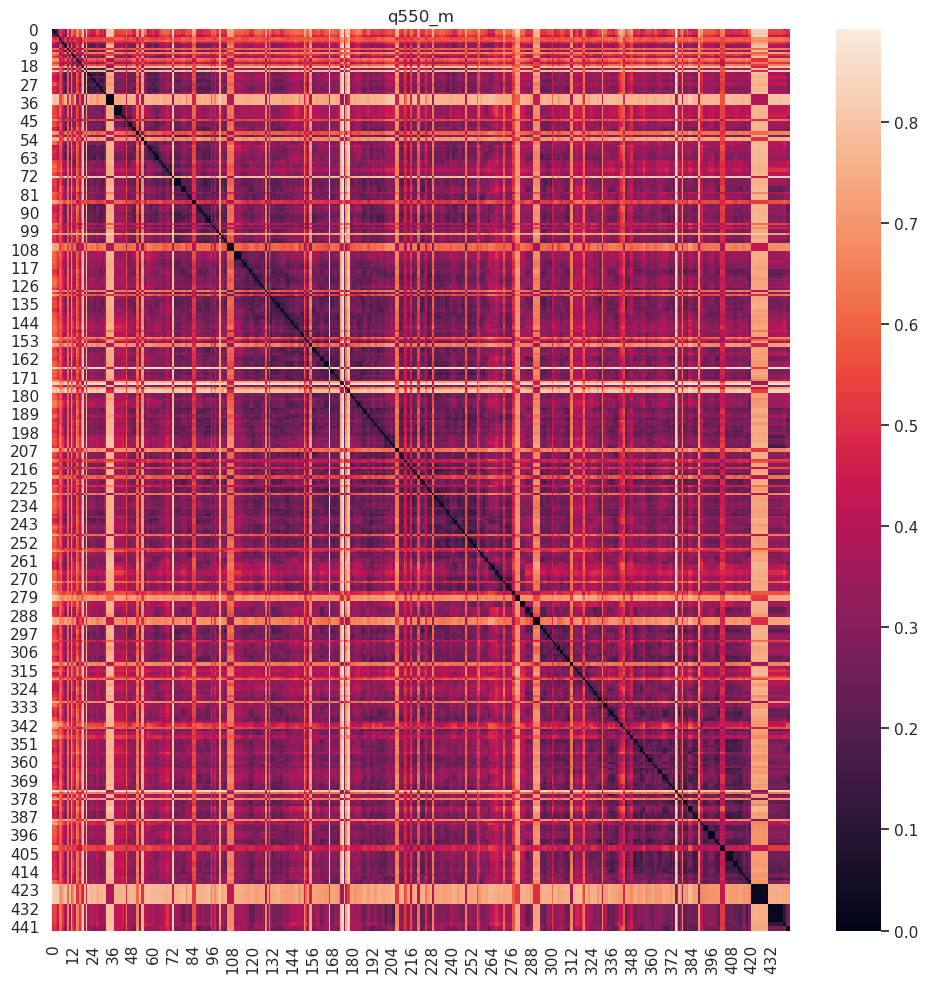

In [98]:
plot_heatmap_subject(q2202_s1_feature_table, 'q2202_s1')
plot_heatmap_subject(q2202_s2_feature_table, 'q2202_s2')

plot_heatmap_subject(q550_f_feature_table, 'q550_f')
plot_heatmap_subject(q550_m_feature_table, 'q550_m')